In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import sem

%matplotlib inline
%config Completer.use_jedi = False


#import required sklearn for logistic regression classifier

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,roc_auc_score, f1_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
#Load the survival / clinical files

clinical_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/Survival/BRCA.clin.merged.picked.txt'

clinical_df = pd.read_csv(clinical_file,sep='\t',index_col=0)

In [3]:
#LOAD BRCA FPKM data for tumour samples, BRCA isoform genes, cis and trans eQTL

all_genes_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/GeneExpression_MAF/BRCA_FPKM_tumour.csv'
all_genes = pd.read_csv(all_genes_file,header=[0,1],sep='\t',index_col=[0])

isoform_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/isoform_switch/BRCA_FPKM_protein_isoform_filtered.csv'
isoform_genes = pd.read_csv(isoform_file,header=[0,1],sep='\t',index_col=[0])

cis_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/eQTL/eQTL_95/BRCA_cis_eQTL_95_ensembl.csv'
trans_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/eQTL/eQTL_95/BRCA_trans_eQTL_95_ensembl.csv'

cis_95 = pd.read_csv(cis_95_file,sep='\t',index_col=0)
trans_95 = pd.read_csv(trans_95_file,sep='\t',index_col=0)

In [4]:
clinical_df

,tcga-5l-aat0,tcga-5l-aat1,tcga-a1-a0sp,tcga-a2-a04v,tcga-a2-a04y,tcga-a2-a0cq,tcga-a2-a1g4,tcga-a2-a25a,tcga-a7-a0cd,tcga-a7-a13g,...,tcga-s3-aa11,tcga-s3-aa14,tcga-s3-aa15,tcga-ul-aaz6,tcga-uu-a93s,tcga-v7-a7hq,tcga-wt-ab44,tcga-xx-a899,tcga-xx-a89a,tcga-z7-a8r6
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
Composite Element REF,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
years_to_birth,42,63,40,39,53,62,71,44,66,79,...,67,47,51,73,63,75,NaN,46,68,46
vital_status,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
days_to_death,NaN,NaN,NaN,1920,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,116,NaN,NaN,NaN,NaN,NaN
days_to_last_followup,1477,1471,584,NaN,1099,2695,595,3276,1165,718,...,421,529,525,518,NaN,2033,883,467,488,3256
tumor_tissue_site,breast,breast,breast,breast,breast,breast,breast,breast,breast,breast,...,breast,breast,breast,breast,breast,breast,breast,breast,breast,breast
pathologic_stage,stage iia,stage iv,stage iia,stage iia,stage iib,stage ia,stage iiia,stage iia,stage i,stage iia,...,stage iia,stage i,stage iib,stage iia,stage iv,stage iiia,stage ia,stage iiia,stage iib,stage i
pathology_T_stage,t2,t2,t2,t2,t2,t1,t3,t2,t1,t2,...,t2,t1,t2,t2,t4d,t1c,t1c,t1c,t3,t1c
pathology_N_stage,n0,n0,n0 (i-),n0 (i-),n1mi,n0 (i-),n1a,n0 (i-),n0,n0,...,n0,n0 (i+),n1a,n0,n3b,n2a,n0 (i-),n2a,n0,n0


In [5]:
#First transpose the clinical datframe
clinical_T = clinical_df.T

In [6]:
#Now drop any patients who are still alive i.e. where col vital_status = '0'
clinical_dead = clinical_T[clinical_T['vital_status'] != '0']

In [7]:
clinical_dead

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,radiation_therapy,histological_type,number_of_lymph_nodes,race,ethnicity
tcga-a2-a04v,value,39,1,1920,NaN,breast,stage iia,t2,n0 (i-),m0,female,2005,NaN,no,infiltrating ductal carcinoma,0,white,not hispanic or latino
tcga-a8-a06u,value,80,1,883,NaN,breast,stage iib,t2,n1a,m0,female,2008,NaN,no,infiltrating ductal carcinoma,NaN,NaN,NaN
tcga-aq-a0y5,value,70,1,172,NaN,breast,stage iiia,t2,n2a,mx,female,2010,NaN,no,infiltrating ductal carcinoma,5,white,not hispanic or latino
tcga-aq-a7u7,value,55,1,584,NaN,breast,stage iiia,t2,n2a,m0,female,2013,NaN,yes,infiltrating lobular carcinoma,4,white,not hispanic or latino
tcga-ar-a1ar,value,50,1,524,NaN,breast,stage iiia,t1,n2,m0,female,2007,NaN,yes,infiltrating ductal carcinoma,5,white,not hispanic or latino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga-ll-a73z,value,55,1,227,NaN,breast,stage iv,t1c,nx,m1,female,2013,NaN,yes,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino
tcga-ol-a5d6,value,71,1,1104,NaN,breast,stage iia,t2,n0,mx,female,2009,NaN,no,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino
tcga-ol-a66k,value,72,1,1275,NaN,breast,stage iia,t2,n0,mx,female,2010,NaN,no,infiltrating lobular carcinoma,NaN,white,not hispanic or latino
tcga-pe-a5dc,value,72,1,1430,NaN,breast,stage iiia,t2,n2a,m0,female,2005,NaN,yes,infiltrating lobular carcinoma,5,white,not hispanic or latino


In [8]:
#Drop any rows where days to death is NaN
clinical_dead = clinical_dead[clinical_dead['days_to_death'].notna()]

In [9]:
#Convert days to death to intergers for plotting

clinical_dead['days_to_death'] = pd.to_numeric(clinical_dead['days_to_death'])

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [10]:
clinical_dead['days_to_death'].sort_values(ascending = False).median()

1272.0

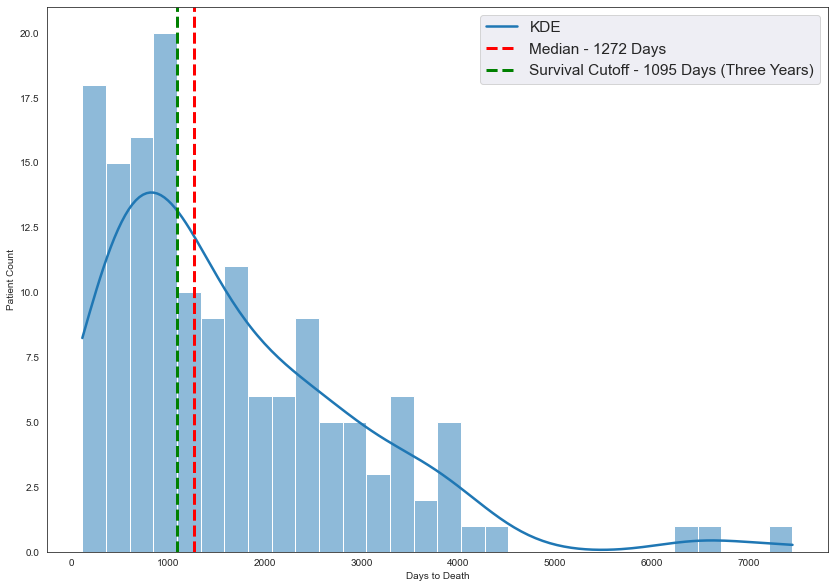

In [11]:
sns.set_style('white')
sns.displot(clinical_dead['days_to_death'],kind='hist',bins=30,kde=True,line_kws={'linewidth':2.5,'label':'KDE'},height=8.27, aspect=11.7/8.27)
sns.despine(top=False,right=False)
sns.set(font_scale = 1.4)

#plt.title('BRCA Deceased Patient Distribution')
plt.xlabel('Days to Death')
plt.ylabel('Patient Count')
plt.axvline(clinical_dead['days_to_death'].sort_values(ascending = False).median(), color='red', linestyle='dashed', linewidth=3,label='Median - 1272 Days')
plt.axvline(x=1095, color='green', linestyle='dashed', linewidth=3,label='Survival Cutoff - 1095 Days (Three Years)')
plt.legend()

plt.savefig('BRCA_deceased_patient_distribution.pdf')

# plt.rcParams["axes.labelsize"] = 15
# plt.rcParams["axes.titlesize"] = 18
# plt.rcParams[""] = 15

In [12]:
#Create function to tell if patient survived for 3 years of more

def three_years(row):
    
    if row['days_to_death'] >= 1095:
        return 1
    else:
        return 0

In [13]:
#Now apply function to dataframe to create a new col

clinical_dead['Three_year_status'] = clinical_dead.apply(three_years,axis=1)

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [14]:
clinical_dead

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,radiation_therapy,histological_type,number_of_lymph_nodes,race,ethnicity,Three_year_status
tcga-a2-a04v,value,39,1,1920,NaN,breast,stage iia,t2,n0 (i-),m0,female,2005,NaN,no,infiltrating ductal carcinoma,0,white,not hispanic or latino,1
tcga-a8-a06u,value,80,1,883,NaN,breast,stage iib,t2,n1a,m0,female,2008,NaN,no,infiltrating ductal carcinoma,NaN,NaN,NaN,0
tcga-aq-a0y5,value,70,1,172,NaN,breast,stage iiia,t2,n2a,mx,female,2010,NaN,no,infiltrating ductal carcinoma,5,white,not hispanic or latino,0
tcga-aq-a7u7,value,55,1,584,NaN,breast,stage iiia,t2,n2a,m0,female,2013,NaN,yes,infiltrating lobular carcinoma,4,white,not hispanic or latino,0
tcga-ar-a1ar,value,50,1,524,NaN,breast,stage iiia,t1,n2,m0,female,2007,NaN,yes,infiltrating ductal carcinoma,5,white,not hispanic or latino,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga-ll-a73z,value,55,1,227,NaN,breast,stage iv,t1c,nx,m1,female,2013,NaN,yes,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino,0
tcga-ol-a5d6,value,71,1,1104,NaN,breast,stage iia,t2,n0,mx,female,2009,NaN,no,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino,1
tcga-ol-a66k,value,72,1,1275,NaN,breast,stage iia,t2,n0,mx,female,2010,NaN,no,infiltrating lobular carcinoma,NaN,white,not hispanic or latino,1
tcga-pe-a5dc,value,72,1,1430,NaN,breast,stage iiia,t2,n2a,m0,female,2005,NaN,yes,infiltrating lobular carcinoma,5,white,not hispanic or latino,1


In [15]:
#Make the index upper case so can match with FPKM data
clinical_dead.index = clinical_dead.index.str.upper()

In [16]:
clinical_dead

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,radiation_therapy,histological_type,number_of_lymph_nodes,race,ethnicity,Three_year_status
TCGA-A2-A04V,value,39,1,1920,NaN,breast,stage iia,t2,n0 (i-),m0,female,2005,NaN,no,infiltrating ductal carcinoma,0,white,not hispanic or latino,1
TCGA-A8-A06U,value,80,1,883,NaN,breast,stage iib,t2,n1a,m0,female,2008,NaN,no,infiltrating ductal carcinoma,NaN,NaN,NaN,0
TCGA-AQ-A0Y5,value,70,1,172,NaN,breast,stage iiia,t2,n2a,mx,female,2010,NaN,no,infiltrating ductal carcinoma,5,white,not hispanic or latino,0
TCGA-AQ-A7U7,value,55,1,584,NaN,breast,stage iiia,t2,n2a,m0,female,2013,NaN,yes,infiltrating lobular carcinoma,4,white,not hispanic or latino,0
TCGA-AR-A1AR,value,50,1,524,NaN,breast,stage iiia,t1,n2,m0,female,2007,NaN,yes,infiltrating ductal carcinoma,5,white,not hispanic or latino,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-LL-A73Z,value,55,1,227,NaN,breast,stage iv,t1c,nx,m1,female,2013,NaN,yes,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino,0
TCGA-OL-A5D6,value,71,1,1104,NaN,breast,stage iia,t2,n0,mx,female,2009,NaN,no,infiltrating ductal carcinoma,NaN,black or african american,not hispanic or latino,1
TCGA-OL-A66K,value,72,1,1275,NaN,breast,stage iia,t2,n0,mx,female,2010,NaN,no,infiltrating lobular carcinoma,NaN,white,not hispanic or latino,1
TCGA-PE-A5DC,value,72,1,1430,NaN,breast,stage iiia,t2,n2a,m0,female,2005,NaN,yes,infiltrating lobular carcinoma,5,white,not hispanic or latino,1


In [17]:
#Check the FPKM DF
all_genes

Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS4Y2,AC005154.5,TMEM272,AC120114.4,BLACAT1,AC006978.2,AL365214.3,AL512506.3,GIMAP1-GIMAP5,Cancer
Gene_ensembl_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000280969,ENSG00000281039,ENSG00000281106,ENSG00000281348,ENSG00000281406,ENSG00000281593,ENSG00000281613,ENSG00000281883,ENSG00000281887,Cancer
TCGA-E2-A15G-01A-11R-A12D-07,7.866571,0.175111,27.364624,8.670967,2.558665,1.928970,2.215282,14.838384,10.524397,19.052122,...,0.0,0.031567,0.083592,0.390052,0.000000,0.325629,0.0,0.000000,0.000000,1
TCGA-E2-A1B5-01A-21R-A12P-07,4.418394,2.943996,27.119087,4.985135,0.999935,4.456954,8.149327,28.237424,10.469930,9.486448,...,0.0,0.054112,0.107469,0.267447,0.074499,0.139546,0.0,0.000000,0.000000,1
TCGA-EW-A2FS-01A-11R-A17B-07,7.154286,0.383271,22.629077,3.829031,1.227351,2.823288,7.049678,28.651534,5.426292,19.119003,...,0.0,0.023637,0.027384,0.262855,0.092203,0.658321,0.0,0.054370,0.000000,1
TCGA-EW-A1P7-01A-21R-A144-07,7.662819,1.129140,25.556876,3.213883,1.116023,7.513366,13.877968,19.519627,3.414307,13.768242,...,0.0,0.083563,0.055320,0.068834,0.811712,0.086198,0.0,0.042714,0.000000,1
TCGA-LL-A5YO-01A-21R-A28M-07,5.059936,0.065756,38.373725,3.006991,1.428246,10.452676,6.648409,17.796223,4.306384,19.987341,...,0.0,0.038525,0.038256,0.000000,0.070720,0.000000,0.0,0.073847,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AN-A04A-01A-21R-A034-07,4.442201,0.079306,23.343134,3.149436,0.784594,0.882086,7.064705,21.917805,1.852359,6.440126,...,0.0,0.000000,0.003418,0.051032,0.099507,0.042603,0.0,0.000000,0.000000,1
TCGA-C8-A134-01A-11R-A115-07,8.910983,0.158778,75.062615,2.276358,3.798579,3.820268,5.251800,23.068440,5.255835,25.897565,...,0.0,0.015504,0.051320,0.134100,1.878398,0.095958,0.0,0.029719,0.000000,1
TCGA-BH-A1ES-01A-11R-A137-07,9.660360,0.026014,37.163885,6.291898,2.435636,0.723370,5.496997,12.611419,5.651720,18.595177,...,0.0,0.000000,0.020180,0.150659,0.111912,0.062888,0.0,0.023372,0.000000,1


In [18]:
#Rename indexes upto patient ID so we can match samples

all_genes.rename(index= lambda x: '-'.join((x.split('-')[0:3])),inplace=True)

In [19]:
all_genes

Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS4Y2,AC005154.5,TMEM272,AC120114.4,BLACAT1,AC006978.2,AL365214.3,AL512506.3,GIMAP1-GIMAP5,Cancer
Gene_ensembl_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000280969,ENSG00000281039,ENSG00000281106,ENSG00000281348,ENSG00000281406,ENSG00000281593,ENSG00000281613,ENSG00000281883,ENSG00000281887,Cancer
TCGA-E2-A15G,7.866571,0.175111,27.364624,8.670967,2.558665,1.928970,2.215282,14.838384,10.524397,19.052122,...,0.0,0.031567,0.083592,0.390052,0.000000,0.325629,0.0,0.000000,0.000000,1
TCGA-E2-A1B5,4.418394,2.943996,27.119087,4.985135,0.999935,4.456954,8.149327,28.237424,10.469930,9.486448,...,0.0,0.054112,0.107469,0.267447,0.074499,0.139546,0.0,0.000000,0.000000,1
TCGA-EW-A2FS,7.154286,0.383271,22.629077,3.829031,1.227351,2.823288,7.049678,28.651534,5.426292,19.119003,...,0.0,0.023637,0.027384,0.262855,0.092203,0.658321,0.0,0.054370,0.000000,1
TCGA-EW-A1P7,7.662819,1.129140,25.556876,3.213883,1.116023,7.513366,13.877968,19.519627,3.414307,13.768242,...,0.0,0.083563,0.055320,0.068834,0.811712,0.086198,0.0,0.042714,0.000000,1
TCGA-LL-A5YO,5.059936,0.065756,38.373725,3.006991,1.428246,10.452676,6.648409,17.796223,4.306384,19.987341,...,0.0,0.038525,0.038256,0.000000,0.070720,0.000000,0.0,0.073847,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AN-A04A,4.442201,0.079306,23.343134,3.149436,0.784594,0.882086,7.064705,21.917805,1.852359,6.440126,...,0.0,0.000000,0.003418,0.051032,0.099507,0.042603,0.0,0.000000,0.000000,1
TCGA-C8-A134,8.910983,0.158778,75.062615,2.276358,3.798579,3.820268,5.251800,23.068440,5.255835,25.897565,...,0.0,0.015504,0.051320,0.134100,1.878398,0.095958,0.0,0.029719,0.000000,1
TCGA-BH-A1ES,9.660360,0.026014,37.163885,6.291898,2.435636,0.723370,5.496997,12.611419,5.651720,18.595177,...,0.0,0.000000,0.020180,0.150659,0.111912,0.062888,0.0,0.023372,0.000000,1


In [20]:
#Create list of non-matched samples

non_matched = list(set(all_genes.index) - set(clinical_dead.index)) + list(set(clinical_dead.index) - set(all_genes.index))

In [21]:
#Drop non_matched sample IDs / indexes from both the clinical and FPKM tables

all_genes_survival = all_genes.query("index not in @non_matched")
clinical_dead = clinical_dead.query("index not in @non_matched")

In [22]:
#Cretae series that only contains the three_year_status column so can map to FPKM table

clinical_dead_3 = clinical_dead['Three_year_status']

In [23]:
clinical_dead_3

TCGA-A2-A04V    1
TCGA-A8-A06U    0
TCGA-AQ-A0Y5    0
TCGA-AQ-A7U7    0
TCGA-AR-A1AR    0
               ..
TCGA-LL-A73Z    0
TCGA-OL-A5D6    1
TCGA-OL-A66K    1
TCGA-PE-A5DC    1
TCGA-UU-A93S    0
Name: Three_year_status, Length: 151, dtype: int64

In [24]:
#Now map the clinical dead 3 series to a new column in relation to the index

all_genes_survival['Three_year_status'] = all_genes_survival.index.map(clinical_dead_3)

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
all_genes_survival

Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC005154.5,TMEM272,AC120114.4,BLACAT1,AC006978.2,AL365214.3,AL512506.3,GIMAP1-GIMAP5,Cancer,Three_year_status
Gene_ensembl_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281039,ENSG00000281106,ENSG00000281348,ENSG00000281406,ENSG00000281593,ENSG00000281613,ENSG00000281883,ENSG00000281887,Cancer,
TCGA-BH-A1FN,11.193642,0.000000,37.112680,6.354279,4.215916,1.264153,4.988159,13.425736,6.692809,27.568143,...,0.065564,0.016277,0.486073,0.112833,0.439606,0.000000,0.012568,0.000000,1,1
TCGA-E9-A1NG,5.735883,0.024517,27.339538,3.377767,1.483986,2.768589,20.757878,20.525206,4.752718,12.605027,...,0.057456,0.028527,0.094658,0.026368,0.059268,0.000000,0.014685,0.000000,1,0
TCGA-AR-A5QQ,8.075531,0.065705,41.191908,1.204924,2.155752,5.481053,6.976960,22.330984,2.574923,7.039335,...,0.092388,0.000000,0.076104,2.098727,0.031767,0.000000,0.000000,0.009353,1,0
TCGA-AR-A24L,5.880391,0.081303,45.519158,4.183880,2.097980,1.120107,8.780616,25.150317,12.147328,22.016759,...,0.000000,0.005733,0.235429,0.055644,0.071471,0.000000,0.019922,0.000000,1,1
TCGA-AC-A23H,1.834530,0.000000,45.027633,9.701227,2.166337,0.932184,6.037117,26.803720,3.765709,14.570241,...,0.039446,0.022850,0.024370,0.027154,0.203451,0.008967,0.037806,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LH,22.575960,0.162804,23.714100,5.677945,2.710319,4.323307,13.506386,23.715134,4.181198,11.052696,...,0.038154,0.018943,0.235715,0.271395,0.236139,0.000000,0.014627,0.000000,1,0
TCGA-B6-A0IN,9.630236,1.350262,13.158749,1.845539,0.655240,3.390361,3.788424,28.543248,3.168748,14.452401,...,0.000000,0.015633,0.058357,0.021674,0.000000,0.010737,0.018106,0.000000,1,1
TCGA-B6-A0IK,2.783289,0.390297,43.278702,4.274955,1.689522,1.195384,4.055354,42.277318,4.487289,13.499105,...,0.000000,0.052654,0.147415,0.319382,0.123067,0.000000,0.091476,0.000000,1,0


In [26]:
#Check the map has worked ... all values should equal zero when subtracted from each other

display(all_genes_survival['Three_year_status'] - clinical_dead_3)
(all_genes_survival['Three_year_status'] - clinical_dead_3).unique()

TCGA-A1-A0SK    0
TCGA-A2-A04P    0
TCGA-A2-A04V    0
TCGA-A2-A0CM    0
TCGA-A2-A0CO    0
               ..
TCGA-LL-A73Z    0
TCGA-OL-A5D6    0
TCGA-OL-A66K    0
TCGA-PE-A5DC    0
TCGA-UU-A93S    0
Name: Three_year_status, Length: 153, dtype: int64

array([0])

In [27]:
#Add column name at level 1 to the three year status column

all_genes_survival = all_genes_survival.rename(columns={'': 'Three_year_status'}, level=1)

In [28]:
all_genes_survival

Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC005154.5,TMEM272,AC120114.4,BLACAT1,AC006978.2,AL365214.3,AL512506.3,GIMAP1-GIMAP5,Cancer,Three_year_status
Gene_ensembl_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281039,ENSG00000281106,ENSG00000281348,ENSG00000281406,ENSG00000281593,ENSG00000281613,ENSG00000281883,ENSG00000281887,Cancer,Three_year_status
TCGA-BH-A1FN,11.193642,0.000000,37.112680,6.354279,4.215916,1.264153,4.988159,13.425736,6.692809,27.568143,...,0.065564,0.016277,0.486073,0.112833,0.439606,0.000000,0.012568,0.000000,1,1
TCGA-E9-A1NG,5.735883,0.024517,27.339538,3.377767,1.483986,2.768589,20.757878,20.525206,4.752718,12.605027,...,0.057456,0.028527,0.094658,0.026368,0.059268,0.000000,0.014685,0.000000,1,0
TCGA-AR-A5QQ,8.075531,0.065705,41.191908,1.204924,2.155752,5.481053,6.976960,22.330984,2.574923,7.039335,...,0.092388,0.000000,0.076104,2.098727,0.031767,0.000000,0.000000,0.009353,1,0
TCGA-AR-A24L,5.880391,0.081303,45.519158,4.183880,2.097980,1.120107,8.780616,25.150317,12.147328,22.016759,...,0.000000,0.005733,0.235429,0.055644,0.071471,0.000000,0.019922,0.000000,1,1
TCGA-AC-A23H,1.834530,0.000000,45.027633,9.701227,2.166337,0.932184,6.037117,26.803720,3.765709,14.570241,...,0.039446,0.022850,0.024370,0.027154,0.203451,0.008967,0.037806,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LH,22.575960,0.162804,23.714100,5.677945,2.710319,4.323307,13.506386,23.715134,4.181198,11.052696,...,0.038154,0.018943,0.235715,0.271395,0.236139,0.000000,0.014627,0.000000,1,0
TCGA-B6-A0IN,9.630236,1.350262,13.158749,1.845539,0.655240,3.390361,3.788424,28.543248,3.168748,14.452401,...,0.000000,0.015633,0.058357,0.021674,0.000000,0.010737,0.018106,0.000000,1,1
TCGA-B6-A0IK,2.783289,0.390297,43.278702,4.274955,1.689522,1.195384,4.055354,42.277318,4.487289,13.499105,...,0.000000,0.052654,0.147415,0.319382,0.123067,0.000000,0.091476,0.000000,1,0


In [29]:
#Now filter the all genes DF with the isoform genes

#First create list of cols / genes to keep
cols_to_keep = list(isoform_genes.columns)
cols_to_keep.append(('Three_year_status','Three_year_status'))


In [30]:
isoform_survival = all_genes_survival.loc[:, cols_to_keep]

In [31]:
isoform_survival

Gene_symbol,TANK,RBCK1,CASC4,DUT,TMEM201,FBLN2,ABLIM3,MPRIP,MCF2L,EHBP1,...,PCGF5,REPS1,CCND3,LRRFIP2,ZRANB2,H2AFV,CEP104,SLK,Cancer,Three_year_status
Gene_ensembl_id,ENSG00000136560,ENSG00000125826,ENSG00000166734,ENSG00000128951,ENSG00000188807,ENSG00000163520,ENSG00000173210,ENSG00000133030,ENSG00000126217,ENSG00000115504,...,ENSG00000180628,ENSG00000135597,ENSG00000112576,ENSG00000093167,ENSG00000132485,ENSG00000105968,ENSG00000116198,ENSG00000065613,Cancer,Three_year_status
TCGA-BH-A1FN,15.343920,16.896624,16.751647,9.053910,3.469054,18.969059,2.182001,6.682397,1.918617,7.225800,...,4.875201,13.634318,9.727431,4.229633,25.029257,31.033869,6.468174,35.239420,1,1
TCGA-E9-A1NG,8.204818,15.724169,30.831324,9.540387,1.458159,41.826503,7.087709,9.316663,1.614837,7.243868,...,7.006416,4.295827,10.860205,6.456335,11.036110,25.771819,5.205502,15.373430,1,0
TCGA-AR-A5QQ,4.584809,37.413581,7.432917,31.326441,3.784303,26.942907,4.418783,5.318138,0.278765,8.252696,...,2.414725,5.561334,21.714776,7.972584,11.563606,32.334497,4.179797,14.306222,1,0
TCGA-AR-A24L,12.187805,11.817051,42.466447,17.772046,1.528907,29.601257,5.565343,7.070899,1.737580,6.467532,...,8.583196,4.694506,10.228295,5.355158,17.109764,40.169837,5.040365,14.045827,1,1
TCGA-AC-A23H,10.839375,17.725220,17.908471,10.923948,2.476160,19.744676,5.266147,4.993341,1.905335,4.650695,...,3.409479,4.394309,8.867406,5.226943,13.281163,34.015799,6.835127,11.712936,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LH,9.579705,23.338886,20.126391,23.172247,3.533242,32.862378,3.116353,7.454451,1.688323,3.913063,...,5.793914,4.752568,24.878755,3.930242,12.494149,32.978206,5.631005,15.788019,1,0
TCGA-B6-A0IN,5.653001,12.949612,13.825296,9.798449,1.953969,22.035637,4.326962,5.437337,1.373668,3.379278,...,3.847809,2.247135,13.729128,2.975186,8.600656,39.169583,2.867297,4.809616,1,1
TCGA-B6-A0IK,6.527808,11.453830,16.448324,19.178110,3.168995,13.938611,4.866697,4.597985,2.722875,3.955684,...,3.526115,4.455779,10.806836,5.182330,12.908030,52.973266,5.113113,5.495684,1,0


In [32]:
#Now drop the cancer col from the all genes survival and isoform survival tables

all_genes_survival.drop('Cancer',axis=1,level=0,inplace=True)
isoform_survival.drop('Cancer',axis=1,level=0,inplace=True)

In [33]:
isoform_survival

Gene_symbol,TANK,RBCK1,CASC4,DUT,TMEM201,FBLN2,ABLIM3,MPRIP,MCF2L,EHBP1,...,ADAMTS12,PCGF5,REPS1,CCND3,LRRFIP2,ZRANB2,H2AFV,CEP104,SLK,Three_year_status
Gene_ensembl_id,ENSG00000136560,ENSG00000125826,ENSG00000166734,ENSG00000128951,ENSG00000188807,ENSG00000163520,ENSG00000173210,ENSG00000133030,ENSG00000126217,ENSG00000115504,...,ENSG00000151388,ENSG00000180628,ENSG00000135597,ENSG00000112576,ENSG00000093167,ENSG00000132485,ENSG00000105968,ENSG00000116198,ENSG00000065613,Three_year_status
TCGA-BH-A1FN,15.343920,16.896624,16.751647,9.053910,3.469054,18.969059,2.182001,6.682397,1.918617,7.225800,...,7.858756,4.875201,13.634318,9.727431,4.229633,25.029257,31.033869,6.468174,35.239420,1
TCGA-E9-A1NG,8.204818,15.724169,30.831324,9.540387,1.458159,41.826503,7.087709,9.316663,1.614837,7.243868,...,13.075343,7.006416,4.295827,10.860205,6.456335,11.036110,25.771819,5.205502,15.373430,0
TCGA-AR-A5QQ,4.584809,37.413581,7.432917,31.326441,3.784303,26.942907,4.418783,5.318138,0.278765,8.252696,...,3.191489,2.414725,5.561334,21.714776,7.972584,11.563606,32.334497,4.179797,14.306222,0
TCGA-AR-A24L,12.187805,11.817051,42.466447,17.772046,1.528907,29.601257,5.565343,7.070899,1.737580,6.467532,...,18.151597,8.583196,4.694506,10.228295,5.355158,17.109764,40.169837,5.040365,14.045827,1
TCGA-AC-A23H,10.839375,17.725220,17.908471,10.923948,2.476160,19.744676,5.266147,4.993341,1.905335,4.650695,...,8.015156,3.409479,4.394309,8.867406,5.226943,13.281163,34.015799,6.835127,11.712936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LH,9.579705,23.338886,20.126391,23.172247,3.533242,32.862378,3.116353,7.454451,1.688323,3.913063,...,1.487765,5.793914,4.752568,24.878755,3.930242,12.494149,32.978206,5.631005,15.788019,0
TCGA-B6-A0IN,5.653001,12.949612,13.825296,9.798449,1.953969,22.035637,4.326962,5.437337,1.373668,3.379278,...,3.018018,3.847809,2.247135,13.729128,2.975186,8.600656,39.169583,2.867297,4.809616,1
TCGA-B6-A0IK,6.527808,11.453830,16.448324,19.178110,3.168995,13.938611,4.866697,4.597985,2.722875,3.955684,...,2.511905,3.526115,4.455779,10.806836,5.182330,12.908030,52.973266,5.113113,5.495684,0


In [34]:
#Save the all_genes_survival and isoform_survival filtered FPKM file to a csv

all_genes_survival.to_csv(isoform_file.split('/')[5]+'_all_genes_survival.csv',sep='\t')
isoform_survival.to_csv(isoform_file.split('/')[5]+'_isoform_survival.csv',sep='\t')

In [35]:
#Perform same filtering but for cis and trans eQTL genes

#First create list of cols / genes to keep
cols_to_keep_cis = list(cis_95['ensembl_gene_id'])
cols_to_keep_cis.append('Three_year_status')

cols_to_keep_trans = list(trans_95['ensembl_gene_id'])
cols_to_keep_trans.append('Three_year_status')

In [36]:
cis_95_survival = all_genes_survival.loc(axis=1)[:, cols_to_keep_cis]
trans_95_survival = all_genes_survival.loc(axis=1)[:, cols_to_keep_trans]

In [37]:
trans_95_survival

Gene_symbol,BTN3A2,TYW1B,ZFP57,CCAR2,CNOT7,XPO7,ERI1,BIN3,INTS10,MCPH1,...,RNF185,SERINC1,BIRC2,TBCEL,RNF6,ZBTB44,EBPL,DPAGT1,NUP50,Three_year_status
Gene_ensembl_id,ENSG00000186470,ENSG00000277149,ENSG00000204644,ENSG00000158941,ENSG00000198791,ENSG00000130227,ENSG00000104626,ENSG00000147439,ENSG00000104613,ENSG00000147316,...,ENSG00000138942,ENSG00000111897,ENSG00000110330,ENSG00000154114,ENSG00000127870,ENSG00000196323,ENSG00000123179,ENSG00000172269,ENSG00000093000,Three_year_status
TCGA-BH-A1FN,4.985915,0.767303,0.681195,6.883253,10.086561,15.108778,3.089854,1.105643,5.632802,2.354664,...,10.898069,168.231835,19.693775,3.310834,11.531175,2.849830,13.843135,10.885329,11.666817,1
TCGA-E9-A1NG,8.839503,3.493300,0.251026,14.641512,8.756788,13.818248,2.919980,2.806848,7.194539,2.354203,...,10.088504,114.977526,16.838717,3.789788,9.777667,3.041201,17.069566,6.267221,5.694486,0
TCGA-AR-A5QQ,9.740210,0.324691,0.265814,12.453214,4.953293,8.503780,3.406305,2.598724,6.274062,1.601645,...,8.236876,34.112663,14.089016,2.405011,5.159876,2.091598,20.522159,7.493056,6.452869,0
TCGA-AR-A24L,5.113456,0.533265,0.348856,7.944163,8.296078,13.625668,1.873039,1.313864,4.443605,2.344667,...,8.444167,168.604652,15.846341,4.880296,10.339302,6.515564,10.725735,7.617709,8.058653,1
TCGA-AC-A23H,1.443108,2.611814,14.369499,6.020071,3.484347,7.095567,1.971463,0.729318,3.726252,0.946755,...,19.182812,111.577657,12.996711,5.425721,10.297985,4.551728,12.185810,11.258160,14.745495,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LH,5.810295,0.828662,0.073182,14.914941,6.778621,12.705485,3.830117,3.069718,9.658060,2.823598,...,13.284429,79.344618,12.747146,2.770500,7.232118,5.633900,18.784883,12.649017,7.767644,0
TCGA-B6-A0IN,6.123478,0.268894,0.000000,7.793838,4.726298,5.288011,1.067155,1.266646,3.556892,1.027337,...,5.468951,80.221810,6.074788,2.283279,6.238650,3.213724,14.449552,10.824751,3.647219,1
TCGA-B6-A0IK,6.347181,2.524114,0.241552,12.748876,8.977944,10.929907,2.451813,1.319716,7.067853,1.517668,...,7.941820,150.225275,9.772073,2.249491,11.659087,3.252297,24.479448,10.074549,15.348660,0


In [38]:
#Save to csv

cis_95_survival.to_csv(isoform_file.split('/')[5]+'_cis_95_survival.csv',sep='\t')
trans_95_survival.to_csv(isoform_file.split('/')[5]+'_trans_95_survival.csv',sep='\t')